In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import torch.nn as nn
import torch
from os import listdir
from os.path import join
import torch.optim as optim
import math
from PIL import Image
from torch.autograd import Variable

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize,Normalize

In [3]:
torch.autograd.set_detect_anomaly(True)
batch_size = 8 # batch size, reduce if facing OOM error
epochs = 100 # number of epochs to train the SRCNN model for
lr = 0.0002 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
UPSCALE_FACTOR = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

cuda


In [4]:
class imgDataset(Dataset):
    def __init__(self, hr_dir,crop_size,UPSCALE_FACTOR):
        super(imgDataset, self).__init__()
        
        crop_size = crop_size - (crop_size % UPSCALE_FACTOR)
        self.filenames = [join(hr_dir, x) for x in listdir(hr_dir)]
        self.lr_transform = Compose([
        ToPILImage(),
        Resize(crop_size // UPSCALE_FACTOR, interpolation=Image.BICUBIC),
        ToTensor()
    ])
        self.hr_transform = Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image
    def __len__(self):
        return len(self.filenames)


In [5]:
train_dataset = imgDataset("/kaggle/input/trainhr",256,UPSCALE_FACTOR)
valid_dataset = imgDataset("/kaggle/input/validhr", 256,UPSCALE_FACTOR)
test_dataset = imgDataset("/kaggle/input/testhr", 256,UPSCALE_FACTOR)
trainloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
testloader =  DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
validloader =  DataLoader(valid_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
from torch import nn, optim
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1),
            nn.PixelShuffle(up_scale),
            nn.PReLU()
        );

    def forward(self, x):
        
        return self.block(x)
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        );
    def forward(self, x):
        
        return x + self.block(x)
    
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        
        self.block2 = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64))

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block4 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block4.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block4 = nn.Sequential(*block4)

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.block2(out1)
        
        out3 = self.block3(out2)
        res = self.block4(out1 + out3)

        return (torch.tanh(res) + 1) / 2

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

In [7]:
from torchvision.models.vgg import vgg16
# Initialize generator and discriminator
generator = Generator(UPSCALE_FACTOR)
discriminator = Discriminator()
generator_criterion = GeneratorLoss()

generator_criterion = generator_criterion.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

optG = optim.Adam(generator.parameters(), lr=0.0002)
optD = optim.Adam(discriminator.parameters(), lr=0.0002)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [9]:
from tqdm import tqdm_notebook as tqdm
import os
from skimage.color import rgb2ycbcr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [10]:
for epoch in range(1, 100 + 1):
    tqdm_bar = tqdm(trainloader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    generator.train()
    discriminator.train()
    for data, target in tqdm_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size
        
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        
       
        fake_img = generator(z)
        discriminator.zero_grad()
        d_loss = 1 - discriminator(real_img).mean() + discriminator(fake_img).mean()
        d_loss.backward(retain_graph=True)
        optD.step()

        fake_img = generator(z)
        fake_out = discriminator(fake_img).mean()
        generator.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()

        fake_img = generator(z)
        fake_out = discriminator(fake_img).mean()
        
        optG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += discriminator(real_img).mean().item() * batch_size
        running_results['g_score'] += discriminator(fake_img).mean().item() * batch_size

        tqdm_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, 20, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    generator.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    if(epoch%4 == 0):   
        torch.save(generator.state_dict(), "/kaggle/working/generator2.pth")
        torch.save(discriminator.state_dict(), "/kaggle/working/discriminator2.pth")
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
        ssim_list = []
        psnr_list = []
        genLoss, disLoss = 0, 0
        tqdm_bar = tqdm(validloader)
        batch = 0
        for data, target in tqdm_bar:
            generator.eval()
            discriminator.eval()

            real_img = Variable(target)
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)
            if torch.cuda.is_available():
                z = z.cuda()

            fake_img = generator(z)
            for i in range(real_img.shape[0]):
                image1 = np.moveaxis(np.squeeze(real_img[i].cpu().detach().numpy()), 0, -1)
                image2 = np.moveaxis(np.squeeze(fake_img[i].cpu().detach().numpy()), 0, -1)
                image1 = rgb2ycbcr(image1)[:,:,0:1]/255.0
                image2 = rgb2ycbcr(image2)[:,:,0:1]/255.0


                ssim_list.append(ssim(
                    image1,
                    image2,
                    win_size = 11,
                    gaussian_weights=True,
                    multichannel = True
                ))
                psnr_list.append(psnr(
                    image1, 
                    image2,
                ))
        print(np.mean(psnr_list), np.mean(ssim_list))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/93 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.


28.58344771723776 0.91751206


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

30.554408998385973 0.9339468


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

29.767380918596427 0.9359455


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31.02552047972182 0.94410384


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31.103914728711537 0.9396695


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31.148155587919906 0.9438677


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31.63921599479668 0.9381007


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

32.0132835743662 0.93603384


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

32.823422489012884 0.9503406


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31.20117104809416 0.9476069


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31.886081258139626 0.94468415


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

31.303138620017933 0.9403521


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33.240939931302975 0.9472564


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33.519431223844705 0.9518404


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

29.937618716138264 0.94694805


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

32.90068687470121 0.94969976


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

34.22759652974868 0.9531741


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33.075034128723935 0.95492494


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

34.3591048916208 0.95186234


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33.222783562294595 0.94965667


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

32.64010478211939 0.94406414


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33.28489313804206 0.9559065


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

34.65681667017587 0.95466673


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33.89286622066657 0.94936544


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

33.277644717176074 0.9500246


In [11]:
real_img.shape

torch.Size([8, 3, 256, 256])

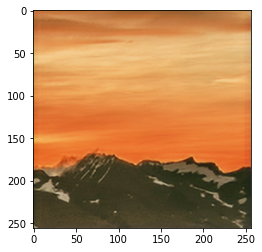

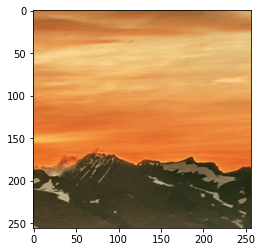

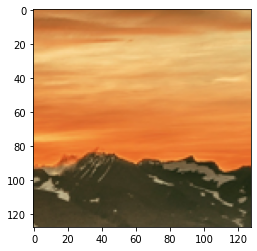

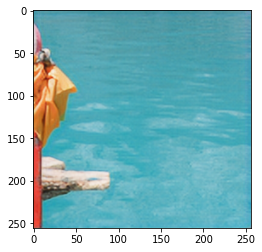

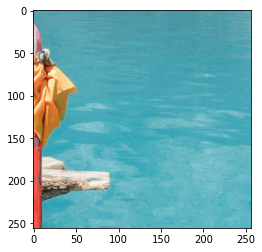

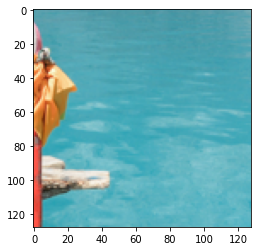

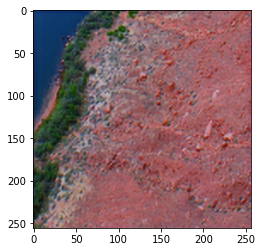

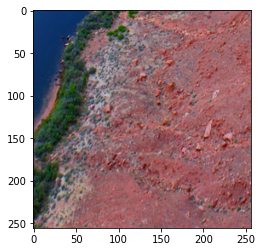

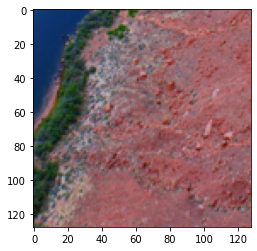

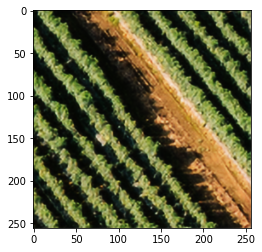

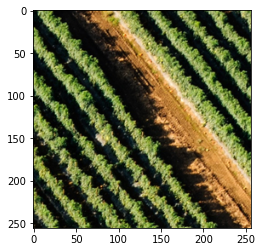

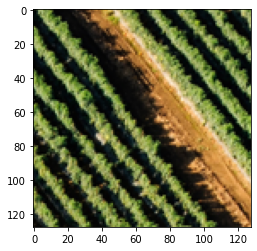

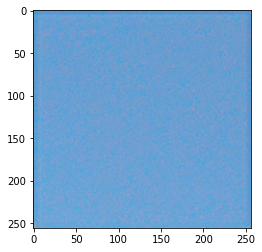

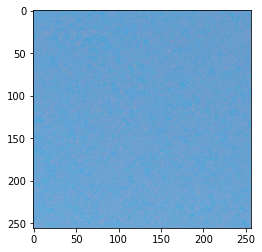

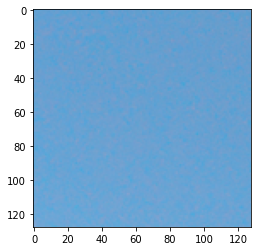

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(5):
    image1 = np.moveaxis(np.squeeze(fake_img[i].cpu().detach().numpy()), 0, -1)
    image2 = np.moveaxis(np.squeeze(real_img[i].cpu().detach().numpy()), 0, -1)
    image3 = np.moveaxis(np.squeeze(z[i].cpu().detach().numpy()), 0, -1)
    imgplot = plt.imshow(image1)
    plt.show()

    imgplot = plt.imshow(image2)
    plt.show()
    
    imgplot = plt.imshow(image3)
    plt.show()

